# Multi-layer Perceptron (MLP)

- **Training set**: LO_SARD102 (0.75 split)
- **Test/Validation set:** LO_SARD102 (0.25 split)
- **Features**: word2vec average
- **Class imbalance processing**: Random Undersampling

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/home/scheuererra68323/venv37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Load labeled dataset

In [2]:
dataset = pd.read_hdf("/mnt/md0/user/scheuererra68323/LO_SARD102/LO_SARD102_word2vec.h5")
print(dataset.shape)
print(dataset.is_vulnerable.value_counts())

(292724, 2)
0.0    269721
1.0     23003
Name: is_vulnerable, dtype: int64


## Split dataset into training and test

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(
    dataset.word2vec_avg,
    dataset.is_vulnerable,
    test_size=0.2,
    stratify=dataset.is_vulnerable,
    random_state=0
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train,
    Y_train,
    test_size=0.25,
    stratify=Y_train,
    random_state=1
)

X_train = numpy.stack(X_train, axis=0)
Y_train = numpy.stack(Y_train, axis=0)
X_val = numpy.stack(X_val, axis=0)
Y_val = numpy.stack(Y_val, axis=0)
X_test = numpy.stack(X_test, axis=0)
Y_test = numpy.stack(Y_test, axis=0)

print("Training Set:")
print(f"{len(X_train)} total")
print(Counter(Y_train))
print()      
print("Validation Set:")
print(f"{len(X_val)} total")
print(Counter(Y_val))
print()      
print("Test Set:")
print(f"{len(X_test)} total")
print(Counter(Y_test))

Training Set:
175634 total
Counter({0.0: 161833, 1.0: 13801})

Validation Set:
58545 total
Counter({0.0: 53944, 1.0: 4601})

Test Set:
58545 total
Counter({0.0: 53944, 1.0: 4601})


## Apply undersampling of majority class

In [4]:
X_train, Y_train = undersample(X_train, Y_train)
print(len(X_train), "total")
print(pd.Series(Y_train).value_counts())

27602 total
1.0    13801
0.0    13801
dtype: int64


## Model definition & Training

In [12]:
init_mode = 'glorot_uniform'
hidden_size=64
model = keras.Sequential(
    [
        layers.Dense(hidden_size,
                     input_dim=100,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),
        
        layers.Dropout(0.1),
        
        layers.Dense(hidden_size,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),

        layers.Dense(hidden_size,
                     kernel_initializer=init_mode,
                     activation=tf.nn.relu),


        layers.Dense(1, 
                     kernel_initializer=init_mode, 
                     activation=tf.nn.sigmoid),
    ]
)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=0.001),
              metrics=['accuracy'])
history = model.fit(X_train, Y_train,
                    batch_size=X_train.shape[0],
                    epochs=100,
                    verbose=True,
                    validation_data=(X_val, Y_val))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0
_________________________________________________________________
Train on 27602 samples, validate on 58545 samples
Epoch 1/100
27602/27602 [==============================] - 1s 24us

Epoch 49/100
27602/27602 [==============================] - 0s 1us/sample - loss: 0.1739 - accuracy: 0.9328 - val_loss: 0.1627 - val_accuracy: 0.9385
Epoch 50/100
27602/27602 [==============================] - 0s 2us/sample - loss: 0.1725 - accuracy: 0.9330 - val_loss: 0.1620 - val_accuracy: 0.9381
Epoch 51/100
27602/27602 [==============================] - 0s 1us/sample - loss: 0.1722 - accuracy: 0.9325 - val_loss: 0.1478 - val_accuracy: 0.9473
Epoch 52/100
27602/27602 [==============================] - 0s 1us/sample - loss: 0.1681 - accuracy: 0.9344 - val_loss: 0.1434 - val_accuracy: 0.9489
Epoch 53/100
27602/27602 [==============================] - 0s 2us/sample - loss: 0.1661 - accuracy: 0.9359 - val_loss: 0.1509 - val_accuracy: 0.9442
Epoch 54/100
27602/27602 [==============================] - 0s 1us/sample - loss: 0.1636 - accuracy: 0.9365 - val_loss: 0.1530 - val_accuracy: 0.9437
Epoch 55/100
27602/27602 [==============================] - 0s 2us/sample - loss: 0.1627 - accuracy:

## Evaluation

In [13]:
Y_pred = numpy.round(model.predict(X_test))

print(classification_report(Y_test, Y_pred))
print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
print()
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:\t{:.6f}'.format(score[0]))
print('Test accuracy:\t{:.6f}'.format(score[1]))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     53944
         1.0       0.69      0.96      0.80      4601

    accuracy                           0.96     58545
   macro avg       0.84      0.96      0.89     58545
weighted avg       0.97      0.96      0.97     58545

Confusion matrix:
[[51907  2037]
 [  163  4438]]

Confusion matrix (Percentages):
[[88.662  3.479]
 [ 0.278  7.58 ]]

Metrics:
Sensitivity (TPR): 0.964573
Specifity (TNR):   0.962239

FPR: 0.037761
FNR: 0.035427

Balanced accuracy: 0.963406

Test loss:	0.105710
Test accuracy:	0.962422


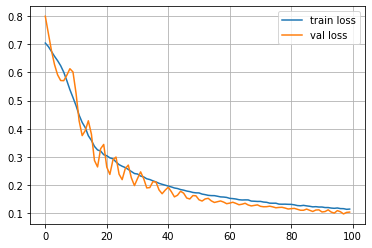

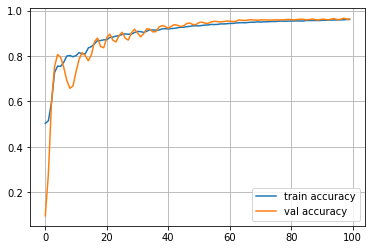

In [17]:
plot_loss(history)
plot_accuracy(history)

In [18]:
model.save('MLP_word2vec_undersample')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: MLP_word2vec_undersample/assets
